# MULTICLASS CLASSIFICATION USING LOGISTIC REGRESSION

<blockquote>This involves classification of data when there are more than two categories. <br>
Instead of y = {0,1}, the cateogoty definition is that y = {0,1...n}.<br>
The procedure is to basically choose one class and then lump all the others into a single second class. This is done repeatedly, applying binary logistic regression to each case, and then using the hypothesis that returned the highest value as the prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Visualisation

In [2]:
from scipy.io import loadmat
data = loadmat('ex3data1.mat')

X = data['X']
y = data['y']

print(f'The size of training data is {X.shape}. The 400 features are (20x20) pixel matrix having image data.')

The size of training data is (5000, 400). The 400 features are (20x20) pixel matrix having image data.


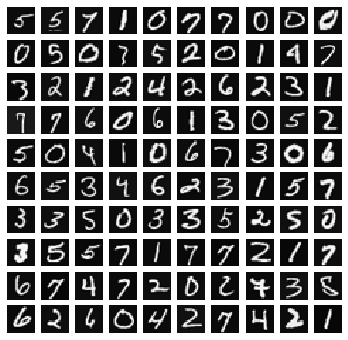

In [3]:
arr = np.random.randint(10,4000,(10,10))

fig, ax = plt.subplots(10,10, figsize=(6,6))
for i in range(10):
    for j in range(10):
        X_vis = X[arr[i,j]].reshape(20,20)
        X_vis = np.rot90(X_vis, k=1)
        ax[i,j].imshow(X_vis.reshape(20,20), cmap = 'gray', origin='lower')
        ax[i,j].axis('off')
plt.show()

## Function Definitions
The cost and gradient functions are identical to that of Binary Logistic Regression.

In [4]:
def feat_norm(X):
    mu = np.mean(X, axis=0)
    sd = np.std(X, axis=0, ddof=1)
    X_norm = (X- mu)/sd
    return X_norm, mu, sd

def sigmoid(theta, X):
    z = X.dot(theta)
    h = 1/(1+np.exp(-z))
    return h

def cost_grad(theta, X, y, lmb):
    m,n = X.shape
    h = sigmoid(theta, X)
    error = h - y
    
    lg_h1 = np.log(h)
    lg_h2 = np.log(1-h)
    
    J = (-1/m) * sum((y.T.dot(lg_h1)) + (1-y).T.dot(lg_h2))
    reg_term = (lmb/(2*m)) * sum(theta[1:]**2)
    Reg_J = J + reg_term
    
    G = (1/m) * (X.T.dot(error))
    regg_term = (lmb/m) * theta[1:]
    Reg_G = np.zeros([len(G),1])
    Reg_G[0] = G[0]
    Reg_G[1:] = G[1:] + regg_term
    
    return Reg_J, Reg_G

def grad_descent(theta, X, y, alpha, lmb, num_iter): 
    J_his = []
    for i in range(num_iter):
        J, G = cost_grad(theta, X, y, lmb)
        
        theta[0] = theta[0] - (alpha * G[0])
        theta[1:] = theta[1:] - (alpha * G[1:])
        
        J_his.append(J)
    return J_his, theta

## Optimisation Methodology: One vs All
<blockquote>
    • Say, for example, if the classifier label is 2, then if $y_{training-set} = 2$, a corresponding new binary vector is created such that the identified positions are labelled as 1 and all the remaining positions are 0.<br>
    • This updated vector is used for minimisation of the cost function as well as optimising the parameters.<br>
    • This process is repeated based on the number of classifiers $[c-list]$. For our case $[c-list] = 10$.<br>
    • At the end of the cycle, for present case, 10 different optimised parameter sets are available. <br>
    • Hence, this approach is called One vs All Classification wherein each classification class is treated as an individual binary regression problem.

#### MultiClass Gradient Descent Function
Modification based on One vs All Criteria

In [5]:
def MC_grad_descent(theta, X, y, alpha, lmb, num_iter):
    class_lst = list(np.unique(y))
    m,n = X.shape
    theta_all = []
    J_his_all = []
    
    for i in range(len(class_lst)):
        y_gd = np.zeros([m,1])
        theta = np.zeros([n,1])
        for j in range(len(y)):
            if y[j] == class_lst[i]:
                y_gd[j] = 1
                
        J_his, theta_opt = grad_descent(theta, X, y_gd, alpha, lmb , num_iter)
        theta_all.append(theta_opt.ravel())
        J_his_all.append(J_his)
        
    return theta_all, J_his_all

#### Iteration on the Learning Rate ($\alpha$)

In [6]:
X = data['X']
y = data['y']

print(f'The default classification values from the data are {np.unique(y)}')
print('Since numbers from 0 to 9 are being predicted and as classifier 10 from the data denotes 0, \n\
all classification values will be converted from 10 to 0.')

y_conv = y
for i in range(len(y)):
    if y[i] == 10:
        y_conv[i] = 0
print(f'\nThe updated classification values in the data are {np.unique(y_conv)}') 

The default classification values from the data are [ 1  2  3  4  5  6  7  8  9 10]
Since numbers from 0 to 9 are being predicted and as classifier 10 from the data denotes 0, 
all classification values will be converted from 10 to 0.

The updated classification values in the data are [0 1 2 3 4 5 6 7 8 9]


In [ ]:
m,n = X.shape
X_upd = np.append(np.ones([m,1]), X, axis=1)
m,n = X_upd.shape
theta = np.zeros([n,1])
lmb = 0.1 # --> A low lambda value for accuracy.
alpha_iter = [0.001, 0.01, 0.1, 0.5, 1]
num_iter = 1500

fig, ax = plt.subplots(1,1)

for i in range(len(alpha_iter)):
    sample_Jhis = []
    theta_cycle, Jhis_cycle = MC_grad_descent(theta, X_upd, y_conv, alpha_iter[i] , lmb, num_iter)
    sample_Jhis.append(Jhis_cycle[-1])
    ax.plot(sample_Jhis[-1], label=f'alpha = {alpha_iter[i]}, lmb = 0.1')
    
ax.legend()
plt.show()

#### Optimised Parameter Results keeping with $\alpha$ = 0.5

In [ ]:
theta_cycle, Jhis_cycle = MC_grad_descent(theta, X_upd, y_conv, alpha = 1 , lmb=0.1, num_iter=1500)
theta_all = np.array(theta_cycle)
print(f'The optimised thetas from all trained classes are stored in the array "theta_all".\
\nThe size of this matrix is {theta_all.shape}')

### Prediction Accuracy
<blockquote> • The $\theta_{all}$ matrix has optimised parameters for every class. Since there are 10 classes, the matrix consists of 10 rows of optimised parameters.<br>
    • In other words, these trained parameters are taken as a whole and used to obtain the prediction matrix {h}.<br>
    • In normal Logistic Regression, if the prediction value from {h} > 0.5, then it is considered as a postive ($y_{pred} = 1$).<br>
    • But in a multiclass setup, a constant number like the one above cannot be taken and the procedure slightly differs. <br><br>
    <b>The training is example is assigned to the class which has the highest prediction value as obtained from $h$. After this, a direct accuracy comparison with the original $y$ matrix is made.</b>

In [ ]:
def accuracy_multi(theta, X, y):
    m,n = X.shape
    h = X.dot(theta.T)
    
    pred = np.zeros([m,1])
    count = 0
    for i in range(len(h)):
        pred[i] = np.argmax(h[i]) 
        if pred[i] == y[i]:
            count += 1
            
    return (count/m)*100

Accuracy = accuracy_multi(theta_all, X_upd, y_conv)
print(f'The accuracy of the Multiclass Classification problem is {round(Accuracy, 2)} %.')